<a href="https://colab.research.google.com/github/MFerrugem/RNA/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoenconder
modificado de https://github.com/bnsreenu/python_for_microscopists/blob/master/085-auto_encode_single_image_V3.0.py

author = "Sreenivas Bhattiprolu" license = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt # Importação padrão do Matplotlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

# Configuração de semente para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42) # Adicionando semente do TensorFlow

SIZE = 256
img_data = []

# --- 1. Carregamento e Pré-processamento da Imagem ---

# Carregar a imagem. Certifique-se de que a imagem 'images/monalisa.jpg' existe.
# O uso de '1' garante que a imagem seja lida em cores (BGR).
try:
    img = cv2.imread('monalisa_original.jpg', 1)
except cv2.error as e:
    print(f"Erro ao carregar a imagem: {e}")
    print("Verifique se o arquivo 'monalisa.jpg' existe no diretório correto.")
    exit()

# Converter BGR (formato do OpenCV) para RGB (formato do Matplotlib/Keras)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Redimensionar a imagem
img = cv2.resize(img, (SIZE, SIZE))

# Converter para array e preparar o batch
img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
# Normalização: Converter para float32 e escalar para o intervalo [0, 1]
img_array = img_array.astype('float32') / 255.

In [2]:

# --- 2. Definição do Modelo Autoencoder ---

model = Sequential()
# Codificador (Encoder)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same')) # Saída: 128x128x32
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same')) # Saída: 64x64x8
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))

# Gargalo (Bottleneck)
model.add(MaxPooling2D((2, 2), padding='same')) # Saída: 32x32x8 (Latent space)

# Decodificador (Decoder)
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2))) # Saída: 64x64x8
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2))) # Saída: 128x128x8
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2))) # Saída: 256x256x32
# Camada de Saída: 3 filtros para corresponder aos 3 canais de cor (RGB)
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same')) # Usando 'sigmoid' para garantir saída entre [0, 1]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
# --- 3. Compilação e Treinamento ---

# Compilação
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

# Treinamento
# O treinamento é feito reconstruindo a imagem de entrada (img_array, img_array)
print("\nIniciando treinamento...")
history = model.fit(img_array, img_array,
    epochs=5000,
    shuffle=True,
    verbose=0 # Reduzindo o verbose para não poluir o console com 5000 épocas
)
print("Treinamento concluído.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Treinamento concluído.



Gerando saída da rede neural...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


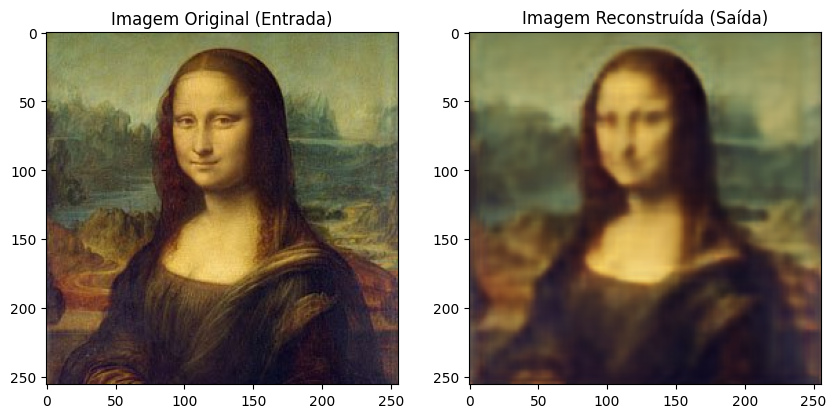

In [4]:

# --- 4. Predição e Visualização ---

print("\nGerando saída da rede neural...")
pred = model.predict(img_array)

# Visualização da Imagem Reconstruída
# Matplotlib é a ferramenta padrão para plotagem
# O reshape é desnecessário pois a saída já é (1, SIZE, SIZE, 3)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Imagem Original (Entrada)")
plt.imshow(img_array[0]) # Mostra a imagem original normalizada

plt.subplot(1, 2, 2)
plt.title("Imagem Reconstruída (Saída)")
# O pred[0] já está no formato (SIZE, SIZE, 3) e normalizado [0, 1]
plt.imshow(pred[0])

plt.show()

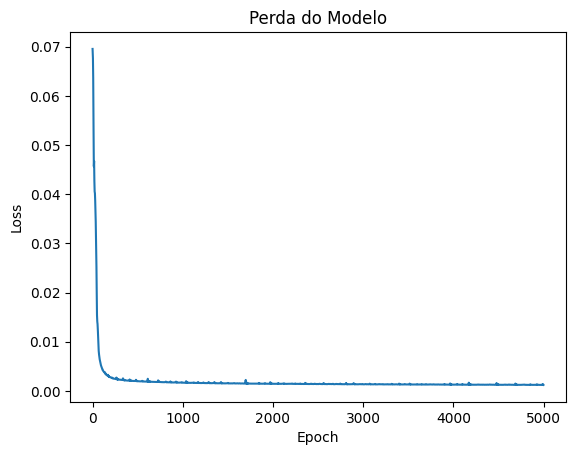

In [5]:
# Opcional: Visualização da Perda (Loss)
plt.plot(history.history['loss'])
plt.title('Perda do Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()